In [1]:
using DrWatson
@quickactivate
using Turing, BSON, Revise, BNP2

┌ Info: Precompiling BNP2 [11504357-4fe5-5405-981c-8cd43ea31635]
└ @ Base loading.jl:1273


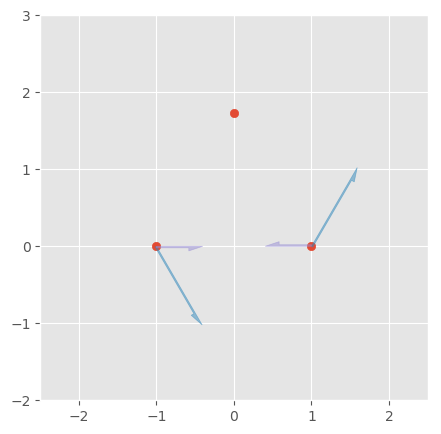

In [2]:
TBP = (
    m = 5e10,
    qs = [
        [-1,  0],
        [ 1,  0], 
        [ 0, √3], 
    ],
    ps = [
        [cos(π/3), -sin(π/3)],
        [cos(π/3),  sin(π/3)],
        [cos(π/1),  sin(π/1)],
    ],
    xlim = [-2.5, 2.5], 
    ylim = [-2.0, 3.0],
    do_addnoise = true,
    noise_level = 0.2,
)

let prob = TBP
    o1, o2, o3 = Particle.(prob.m, prob.qs, prob.ps)
    f1 = forceof(o1, o2)
    f2 = forceof(o2, o1)
    
    ###
    
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(prob.xlim)
    ax.set_ylim(prob.ylim)
    
    plot!(ax, o1; do_plotvelocity=true)
    plot_force!(ax, o1, f1)
    plot!(ax, o2; do_plotvelocity=true)
    plot_force!(ax, o2, f2)
    plot!(ax, o3)
    
    fig |> display
end

;

In [25]:
using BenchmarkTools

let prob = TBP, n_steps = 10
    space = Space(Particle.(prob.m, prob.qs, prob.ps))
    sim = DynSysSimulator(1e-1)
    
    simulate(space, sim, n_steps)
#     @btime simulate($space, $sim, $n_steps)
    @btime begin
        space = $space
        for i in 1:$n_steps
            space′ = transition(space, 1e-1)
            space = space′
        end
    end
end

;

  6.266 ms (2150 allocations: 143.91 KiB)


In [30]:
traj = let prob = TBP, n_steps = 50
    space = Space(Particle.(prob.m, prob.qs, prob.ps))
    sim = DynSysSimulator(1e-1)
    
    HTML(
        animof(
            space, sim, 2 * n_steps; 
            xlim=prob.xlim, ylim=prob.ylim
        ).to_html5_video()
    ) |> display
    
    @info "" positionof(space) velocityof(space) stateof(space) accelerationof(space)
    
    traj = simulate(space, sim, n_steps)
    
    prob.do_addnoise ? 
        traj[1:n_steps] .+ prob.noise_level * randn.(size.(traj[1:n_steps])) : 
        traj
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAGFe21kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAC3ZliIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGhwHgdr8wTD+3aYkOY+t2GtfTX0EL\nWvXuyPgFCc5A6MJnRBnagMpRcclrp6FJLA8/gDzrhSB3BPITWC6mJvn+yyJK7Ql5YU4bJHyELuZG\n/+O1phS1JVD+YpVnvMZMqzWf3ByZ2q6BCRC7ELIIK8CJNMAGaeAH0koOMF+rBOwzkF9PYRveOS6k\nBeAdmQxMoIZpiIXdhjPafLxt73wW/oMhkKji5R2Aq64XxPeqMouON51W8uwZOdKfR+10K36hC0Le\nw8RXCMq+8XcHIkHRjitNBMDUYI+zAMdMNeBcn+Dvja3Qn3Z8eso44Bk3h80BZU2EMnogAc1LN6cg\nBckrU+oVkm8+yItBPFyLPhrt0AcLzvQn8yHkRhED08w4id7hfNL9GilksD0XDSmQgngIaMurraok\nh1l/8Oa2TrMixsKNQRtkvXTBCLs2ypYf3889uEimOxChcnQ1QovKqv2+ZaHJo7n0WvuvqnVD+8Fw\nd99OptDu6HHlFiDQLu+2yE5Ns3D/FE0KWxe3Dv4fkxkqHMQlB9QVKRZ623FNo70F+KcYLknv3IZm\nNy85uzJDPAAPgoCmtiBjEvzjuD6+2NB9mcX0KA5frSD3FWzbaYq976JhAGFhv1xKrE//dvtwMw2S\nzo4cS1bdKR4ocFvLwguHZ61ZSK35Fovkt4TCF8jxG2KE/WKXt+6NXYFmdlbboANuxp/5OZe8qI14\nWrShajH2Iluii+AWcjByZnaVqlHpfxJPtOh6aAnsPQzVacvZqozbxKeIP6m3Gttk6WodBc2UInmT\nJYolPlKT7SfM+a1kwK2E4imIAMSDtTSxuNxFQ7Vpwa+EXjDHF1HHeG2bsPJU768qaNTng4+Ud6bd\nAOSCP27p8Naq7cvgOeMCr+P8ExqoYfbUoL8azRghl9WtlgQN75rd2XxXP/CtVm5eLK9lde+I5KE2\nSrNbvgHNXODAromi68FpwNXZdawi6Jtlf2CwwFuyLzqjqvqbm61ymHfaJeX24LEY786urWa34H07\nYTRgIbvK2WVE+DBmy6OivMskwFLrsFUBAx8+mLg4VycGP6GGQw8RXkfxh1bvcXGcQ/mZVcigH/na\nzTVaqCoAUDIlUzDaJVdftrIE9HOh0qHSw5vTzyHR+NUws4MXA3Uo2JsKoIHUCgEHXwadF8FiFCwG\nDERG9qJDjdE3k6oWcczssFUdUNrGy5HWhuwCh7Cl5vi6IOQj+bi0jedlQ0PcZmhz1OUGioU0oSKH\nodE02uTZlGk+INK6UIEEcngqUkgO3IMvnABBkIL/Ov4IS/sKZoyfaTZ8I6hu7mE+NGFj+iJDT8/t\nMp91lhao4iX3X4bt6ZUxc3ergxeafaaELb4EKn6vBnwTRRBl6Y6Il/M+H4B82HI+3Pt8fVv9Bgh7\nt3O43+PbZ0pr2LlhEm9G1TOzwtMKM8JdxngmYBOTbDTefDRMmhnzwEIskQBGipQaV1ZAgENk74GI\na+Wy2+/1WwzHLTWM4l5gZ9UPPIQXUqifSZQZwzFmf799bT9fScL+A4Jagza2O8KHAARcQN63mUt4\n6OHuV7Bx4Li0146g7fx/nAi7iLFYlnqQBNJdCI/OUAAJShCEiSWK/1M++aR2d2Yyl+VUySW4CmBJ\n6mnOJDLIAq2hNHgb8c4WhDT9S+s+NKGF8yzWefTjd3w9ZZ9xW5Nmzl4Zsiwa0SIf69u6P87dMgy0\n59WzXEM02LKyYagiPWN+0pyE96ZAW+dXnRAtIMfuTCBTBNWPJ6LBDFLOKp5g8Tzv6x+/aUFXPpmL\nEqPwfL/oslGgx9PQ5ca8UT10j8500RRwrhbUZNoMwVaUnQMyx4Fu0dxUqujAWnhKRpCxwHNa+bHD\nunG/Dg9pbcnjxtfqHpP9icJx0o/lDEUOxxGZIZGuPFCCrJr4v4xOsKuRP6ox3fY8uxWTFUA+Jjez\ndcRszoXDnSk2T0qCSYvAsGlDJVumr4yqADy6t/ciBHilY4uLMCzCYpP5bjX4fPTRKbXpX9MEL9iC\ndq/k71qqfYzAHhrAYBr/9Iosn63yUJi1u5RbfUNdyy8J0jn/6XtnvmJA5Ab35mOdS3yjxToRC6g0\n7+Oj46yy8Oy8o/LO97Qr6SMZ0KHv9wAuI+Hu0DRdv4+D5eJh/3tmac108XrxmmcDRRaZOUQQBcII\nPHJX16Xp+Tyl3yvVioYSaXwSCF7JTrGf44Gux2ug9SMstPQqTani9K2PNm4vYqCm8HY38CSGcp0U\n4SZiAAAWvLCeUYKIHhh2hzOiY+yrab6GaeSCB7q22hFHHr6N3ph33pY4h+3uQbB+SEW7AL+ug4Xi\nzU8edJUHoHAnU990MtMgLDV3SVMS3ua3XQq+KAKhXaHqEiUoNURydS4V6fRw1ow7tbRKzPH06bo4\nCergbXNB+qX83wxaY59DNw4KjAne0NnRlgW3hEQjaTLvS4gaWEsPHNoiVKZQXIpcg2I81Kbdafyn\n4lGL2b12ELFwot8meElNMtaGt8dO7yj12286bm5SIyQmrcHQ7Y3CZ6onzhV+cV2Md9L/AzTtnim/\nffffHnWacAoG9l8thqYfGnqN3nL1Sj395GDIbZzkonmrp8T3Y55r5SlAfGMkVR6lUGKQGBGz0/D1\nOcVkQWO+78LRCqvxmfmFnDDNWNyMlQkHe6MFtZxjIVhSrgHV9RnFlg11XAoJkEhINIkOudc3AbBE\nILGW5WGTu3BWI2rjIJmNnNCm0AviQs8QTf0Ks15oWyQOFW

┌ Info: 
│   positionof(space) = [-1.0, 0.0, 1.0, 0.0, 0.0, 1.7320508075688772]
│   velocityof(space) = [0.5000000000000001, -0.8660254037844386, 0.5000000000000001, 0.8660254037844386, -1.0, 1.2246467991473532e-16]
│   stateof(space) = [-1.0, 0.0, 1.0, 0.0, 0.0, 1.7320508075688772, 0.5000000000000001, -0.8660254037844386, 0.5000000000000001, 0.8660254037844386, -1.0, 1.2246467991473532e-16]
│   accelerationof(space) = [1.2514312500000002, 0.72251416905981, -1.2514312500000002, 0.72251416905981, 0.0, -1.44502833811962]
└ @ Main In[30]:12


In [29]:
using BNP2: pqof, vec2list

@model three_body(traj) = begin
    m = 5e10
    u ~ MvNormal(zeros(12), 5)
    q, p = pqof(u)
    space = Space(Particle.(m, vec2list(q), vec2list(p)))
    for i in 1:length(traj)
        space′ = transition(space, 1e-1)
        traj[i] ~ MvNormal(stateof(space′), 5e-1)
        space = space′
    end
end

mf = three_body(traj[2:21])

@time chn = sample(mf, NUTS(100, 0.65), 200)

chn |> display

let prob = TBP
    bson("three_body-noise=$(prob.do_addnoise).bson", chn = chn)
end

;

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/kai/.julia/packages/Turing/MoqTc/src/inference/hmc.jl:553


Object of type Chains, with data of type 100×24×1 Array{Real,3}

Iterations        = 1:100
Thinning interval = 1
Chains            = 1
Samples per chain = 100
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = u[1], u[2], u[3], u[4], u[5], u[6], u[7], u[8], u[9], u[10], u[11], u[12]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean     std  naive_se     mcse      ess   r_hat
  ──────────  ───────  ──────  ────────  ───────  ───────  ──────
        u[1]  -0.4860  0.0915    0.0092  missing   2.1474  1.8936
        u[2]   0.0235  0.0527    0.0053  missing   3.9007  1.3180
        u[3]   1.4007  0.0948    0.0095  missing   8.1475  1.0236
        u[4]  -0.1325  0.0583    0.0058  missing   2.0408  2.1367
        u[5]  -0.9500  0.0535    0.0054  missing  16.6004  0.9922
        u[6]   1.8582  0.0

1033.701831 seconds (270.15 M allocations: 41.217 GiB, 0.72% gc time)


In [23]:
q̄s = let U = hcat(get(chn, [:u]).u...)', n_steps = 50, do_map = true
    m = 5e10
    do_map && (U = mean(U; dims=2))
    q̄s = zeros(6, n_steps)
    for i in 1:size(U, 2)
        u = U[:,i]
        q, p = Vector{Float64}.(pqof(u))
        space = Space(Particle.(m, vec2list(q), vec2list(p)))
        traj = simulate(space, 1e-1, n_steps)
        q̄s = q̄s + hcat(positionof.(traj)...)
    end
    q̄s / size(U, 2)
end

;

In [24]:
using BNP2: TwoDimPath, animation

let prob = TBP, q̄s = q̄s
    xlim = prob.xlim
    ylim = prob.ylim
    
    fig, ax = plt.subplots(figsize=(5, 5))
    
    function reset!(ax)
        ax.clear()
        !isnothing(xlim) && ax.set_xlim(xlim)
        !isnothing(ylim) && ax.set_ylim(ylim)
    end
    
    init!() = reset!(ax)
    
    function draw!(t)
        reset!(ax)
        plot!.(Ref(ax), Particle.(nothing, vec2list(q̄s[:,1])))
        plot!(ax, TwoDimPath(q̄s[1,1:t], q̄s[2,1:t]), "--", alpha=0.5)
        plot!(ax, TwoDimPath(q̄s[3,1:t], q̄s[4,1:t]), "--", alpha=0.5)
        plot!(ax, TwoDimPath(q̄s[5,1:t], q̄s[6,1:t]), "--", alpha=0.5)
        plot!.(Ref(ax), Particle.(nothing, vec2list(q̄s[:,t])))
    end
    
    anim = animation.FuncAnimation(fig, draw!; init_func=init!, frames=1:size(q̄s, 2), interval=50, blit=false)
    HTML(anim.to_html5_video()) |> display
end

;

HTML{String}("<video width=\"500\" height=\"500\" controls autoplay loop>\n  <source type=\"video/mp4\" src=\"data:video/mp4;base64,AAAAHGZ0eXBNNFYgAAACAGlzb21pc28yYXZjMQAAAAhmcmVlAAA9vG1kYXQAAAKhBgX//53cRem9\n5tlIt5Ys2CDZI+7veDI2NCAtIGNvcmUgMTUyIC0gSC4yNjQvTVBFRy00IEFWQyBjb2RlYyAtIENv\ncHlsZWZ0IDIwMDMtMjAxNyAtIGh0dHA6Ly93d3cudmlkZW9sYW4ub3JnL3gyNjQuaHRtbCAtIG9w\ndGlvbnM6IGNhYmFjPTEgcmVmPTMgZGVibG9jaz0xOjA6MCBhbmFseXNlPTB4MzoweDExMyBtZT1o\nZXggc3VibWU9NyBwc3k9MSBwc3lfcmQ9MS4wMDowLjAwIG1peGVkX3JlZj0xIG1lX3JhbmdlPTE2\nIGNocm9tYV9tZT0xIHRyZWxsaXM9MSA4eDhkY3Q9MSBjcW09MCBkZWFkem9uZT0yMSwxMSBmYXN0\nX3Bza2lwPTEgY2hyb21hX3FwX29mZnNldD0tMiB0aHJlYWRzPTE2IGxvb2thaGVhZF90aHJlYWRz\nPTIgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJheV9j\nb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2FkYXB0\nPTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtleWlu\ndD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2Fo\nZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9\nNjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAACU1liIQAN//+9vD+BTY7mNCX\nEc3onTMfvxW4ujQ3vc4AAAMAAAMADuPlocG+vHIc0AAAWwAGhwHgdr8wTD+3aYkOY+t2GtfTX0EL\nWvXuyPgFCc5A6MJnRBnagMpRcclrp6FJLA8/gDzrhSB3BPITWC6mJvn+yyJK7Ql5YU4bJHyELuZG\n/+O1phS1JVD+YpVnvMZMqzWf3ByZ2q6BCRC7ELIIK8CJNMAGaeAH0koOMF+rBOwzkF9PYRveOS6k\nBeAdmQxMoIZpiIXdhjPafLxt73wW/oMhkKji5R2Aq7hvie9Ultvz8Eq3l2SMVYQA9gQCL3UIWhb2\nHiK4RlX3KGXeEg6McVpoJgajBHdwNFfXAuUel+NrcqqJVAq+IryXENtCzmgAAAMAAAMBwM+o/Hp0\nclLh/tnIBwXem2YcrfRKhewzzPPDdxGjRSyWB6LhpS9WTELBYb0VtUSQ6y/+HNbJ1mRY2FGoI2yX\nrpghF2bZUsP7+ee3CRTHYhQuToaoUXlVX7fMtDk0dm4q73V1Tqh/eC4O++HVS4HudmKx/WKNuRhx\nU6z8E0lkLDlU/6abuR1J4VP38GCCiRqcL3RL3TniYcRrARJvNf6/EJiH3TrAhv333CptLAQPBwoz\nPVe6sVtkS6w/QZ1AbQYed41L1dHmb78Y+wE1CAu4QRrPgAAACcXAstyBC95uZE00sxry4d23CfnX\n83Q0jn8mTRL5MUSuz+reBGXwII4xzFvKCIHcmBmgyC4PmBoRFUjcyVuAXwuSmonDNzuV4DSetEdR\nGANOpoNRj78W9pow7KAF78ZHGlOYxeqwji2dBDBaK3TexBOgdEXS5ZE376DIkQN8Z8aGuMH5o1II\nWHtODx49Wi2oKcM31I6znpAT84cTuFiWKNNYCi13VnM14UT1CZ4zZnxWWoTWU4xnnB7T0NuaPENt\nCIUga3CBzEkEN3lZHiMYHgCSS4byxbsyonoKe3cTH0CbjatOqjZwSzVHXy7rnBj/0Gh9Nkuaqqge\niyc+/1tDBUxWsKl3qRjLU2QpVq1+H5XL1h/woxY1vML5QsWn3sKGBSVlfA82Qy1aV1+gdneQjLIf\nd/lh82sGXpiUVftxt3goR35OPk58FaI0CxpEj0UxmGrbHxWFK+cg5bbnQ5r/qekR8Kry/GVnKsnm\nrqbb9q2Gb9Gr/oh6Vwww/oHqz37cXZyMqFW6SOyRWc37cQatURVdjH7hvXpC+irtvGEgAAEj8Z9N\np0G9cp/Lrjtx+UCIwK/+PO2DFtbkQwXd0UqO679V7Cr9pgJaftfSf0+vGydoY4qaScABpUKD4YHK\nmy1QABKSS5tPRX+BiDakVdRYa367F5gJ0SvX4dycEDSMO9Bei5MXPrlY0tYLBD/o0LdHN8Ingz/p\nYNP0wFsgJDYmpHy/v8QvZ+3k7sKV11KKrrNWN6Wqi8oOdDl2CkaYXcbtMYtPvm7gEL22PiQ6nsCi\niZrp0ejIwMmwfc35+Ct1gymMySf3zDO5flE2+ckKqlDQl10eTfMfz9k5JL8irbe8466twWQ+bEjA\neqW3uqqRXAAU9a4TjNyi6Hsu3FBaya7L3YKIONNwt2nQbCEnppbpNsJ9CYLb/6fR4+4V9PK4EO+p\nb1TWItekdvKsuOy+cObjbptTUZYrv2OT/gR6uZtpW15Xg7QxTI1YC3K/rJhS+Cmh+PF8Zn9D+fhm\ng/VG6el5dcKOjry/glnnaqLZw0cpDZde65voqy7e3QLXmkAP7br1fSDLYD1qGXUVPbU1ETsSOV/k\n7cUphC52V4gOb5CTUXiVmgGZ61BGK+2KrS4fn42pViePR3iIo5vb+grsnJDIBdw+zKeRQzMnYu5g\nU8LuAXCjJl/3OcMlljVLh+Tg0Feo82oY5B7NaWVFcSB3prPIXfLUE8QqPGJupgAe4j4AQLTaseqq\nRwv+hqBkDdzs7pm1mWlhxrMn10zxk2uImMbPu/P8jChPtxo8AOC06c4A9wbIrpHvYWFHO24mohIS\nyN3Wfa6KGugOt5DwpNo1Ox/i7EUAVpKh4WuOKuUOfoOoGK9TWIPKdKJPz3gYAqghcax7fuPPo+jw\nbDUaUrE4aEshcTJ+Ts8oVvB+CsiibQ7ZqQ9UjHCl93TWYUrKjSu8iGjqGM7QWe7yeMQtxrPGaOBo\n3LKpt/QM+CJDDfmf3OxdO99IfFEenbjgO8AABll0W61uCR/QZ9qhsIZGYPVWCRgpnri29taMmHhU\nySb5xL7YX7zcyi9rtROaB8MXS1k38UtaJGCkxtisyZ1PD6henEbq1xILZuzaCBDkaaV041FXYcY8\nOyZ7XqlMMK7MCWR/tCahf2rUYBGlu4tVqfmtwPLpAKQ34Vmp4B7gtpqD8xLA6BJjMT5gVnVenV65\npqUrQDBZiqjptOUg4lt6ntJD8SmNYc/Xuc7zkS3umAI2IUMGoFEUKclZFu7JbQT442tnA8m/Nzaz\njLbHZN+jQ26H/4nwUiDYsCRsSKQXn1HceYkEuHgGfhphF9ltTWjjfwQfL9eOQjidMz9CZ9NGNjqz\nZpk3u1ZOOyTR+MqqOlwF99XrRKczEMp7cx0CXUL892qNFPVARI2mTN4pfOO64ANzKYNqS7oJeZXB\nveyeAx9j2XNsKlo5r0OpyoWlbb7mEV7ixTSHaEs1yNTI1mTSFVPvsp5zsD/iYtRHtcdkx+6eEDgQ\n1QB9XQCP9Z/tBm9u3X3Liv9W8yWuhfrCaR74dXhmcqiojUScOj32gNwxvP97UD65RmCCiEbUslL+\naSFaGjax42n/3dRc60jdU+INqmCOqwLDXu7ioOxJqo/8S7